This notebook uses the model from https://huggingface.co/google/vit-base-patch16-224-in21k

All seeds have already been set to 42, however if you will run torch using cuda, expect there to still be slight variations in the results if you rerun it. This is due to torch using non-deterministic algorithms (these are 3x faster than deterministic ones for this model at least from my testing)

Based on the code from "may15_VIT3.ipynb" in old

Overall:
- uses 8 epochs, should take 30 minutes at most
    - could be improved setting it so that the model trains forever (like say until 20 epochs) until the validation loss plateus
- has L2 regularization
    - ctrl+f "weight_decay" to find the line that sets this
- NO dropouts 
    - from testing may15_VIT2 VS may15_VIT3, applying 0.2 dropout made the validation loss slightly bigger, but maybe different values of dropout (0.1, or 0.5) would do better
- uses the initial image preprocessing transforms from may13_VIT1.ipynb
    - this achieves the lowest training loss with lower validation loss as well, but it has the biggest gap (difference) between training and validation loss

Useful documentation links for finding what parameters we can change:

HuggingFace:
- https://huggingface.co/docs/transformers/v4.51.3/en/main_classes/trainer#transformers.TrainingArguments
- https://huggingface.co/docs/transformers/en/model_doc/vit#transformers.ViTConfig

PyTorch:
- https://docs.pytorch.org/vision/0.9/transforms.html
- https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Compose.html


May 15 B, changes by justin
- returned to my first iteration of VIT
- more generous patience

results:
- stats are much more different than the one ran in Google Colab
- overfits alot more (very low training loss) while validation loss keeps rising
- issues: pest and fungi, healthy and virus

In [22]:
## if running in Google Colab, do these
# !pip install datasets=='3.5.1' evaluate torch torchvision transformers Pillow numpy scikit-learn 'accelerate>=0.26.0'

In [23]:
from datasets import load_dataset, Image
import os
"""
.venv/Scripts/activate

python -m image_process
"""
base_output_dir = "model" ## if you wanna save different models, just make a new git branch, saving a VIT model takes up A LOT of space
os.makedirs(base_output_dir, exist_ok=True)
dataset = load_dataset("potato_train/train")
filenames_ds = load_dataset("potato_train/train").cast_column("image", Image(decode=False))

filename_col = [x['image']['path'].split('\\')[-1] for x in filenames_ds['train']]
dataset['train'] = dataset['train'].add_column("filename", filename_col)

We retrieve the feature extractor from our desired VIT model

In [24]:
from transformers import ViTImageProcessor

# import model
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTImageProcessor.from_pretrained(
    model_id
)
feature_extractor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

These are the steps used to preprocess the images and to perform data augmentation on the training dataset.

In [25]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomRotation,
    Resize,
    ToTensor,
    ColorJitter,
    RandomAffine,
    # Pad,
    # RandomCrop
)
from PIL import Image  # Import PIL for RandomAffine's resample
import torch
import numpy as np

def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed = 42
set_seeds(seed)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
size = (feature_extractor.size["height"], feature_extractor.size["width"])

training_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    RandomRotation((-30, 30)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ColorJitter(brightness=0.3, contrast=0.2, saturation=0.1, hue=0.05),
    RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), interpolation=Image.BILINEAR),
    ToTensor(),
    normalize
])

def training_image_preprocess(batch):
    batch["pixel_values"] = torch.stack([training_transforms(img) for img in batch["image"]])
    return batch

def preprocess(batch):
    inputs = feature_extractor(batch['image'], return_tensors='pt')
    inputs['label'] = batch['label']
    return inputs

In [26]:
import torch
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

We split the dataset. 80% for training, 20% for testing.

In [27]:
train_test_split = dataset["train"].train_test_split(test_size=0.2, shuffle=True, seed=42)
dataset_train = train_test_split["train"]
dataset_test = train_test_split["test"]

In [28]:
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label']
num_classes, labels

(6,
 ClassLabel(names=['Bacteria', 'Fungi', 'Healthy', 'Pest', 'Phytopthora', 'Virus'], id=None))

In [29]:
prepared_train = dataset_train.with_transform(training_image_preprocess)
prepared_test = dataset_test.with_transform(preprocess)

Save images of preprocessed images (both train and test)

In [30]:
import os
from torchvision.transforms.functional import to_pil_image

def save_unnormalized_images(prepared_dataset, raw_dataset, directory: str):
    os.makedirs(directory, exist_ok=True)
    for index, item in enumerate(prepared_dataset):
        if index >= 10:
            break
        pixel_values = item["pixel_values"]
        image = to_pil_image(pixel_values)
        label_filename = raw_dataset[index]["filename"]

        name_without_extension, extension = os.path.splitext(label_filename)
        filename = f"pp_{name_without_extension}.png"

        filepath = os.path.join(directory, filename)
        image.save(filepath)


save_unnormalized_images(prepared_train, dataset_train, f"{base_output_dir}/preprocessed_train_images")
save_unnormalized_images(prepared_test, dataset_test, f"{base_output_dir}/preprocessed_test_images")

In [31]:
import evaluate

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=1)
    results = {}
    results.update(accuracy_metric.compute(
        predictions=predictions, 
        references=p.label_ids,
        )
    )
    results.update(f1_metric.compute(predictions=predictions, references=p.label_ids, average="weighted"))
    return results
#

Training Arguments, you can apply stuff like 
- L1 or L2 regularization
- hidden dropouts

etc.

In [32]:
from transformers import ViTForImageClassification, Trainer, TrainingArguments, ViTConfig
#from transformers.trainer_utils import IntervalStrategy, SchedulerType
#from transformers.training_args import OptimizerNames
from transformers.trainer_callback import EarlyStoppingCallback
import hf_xet

training_args = TrainingArguments(
  output_dir=base_output_dir,
  per_device_train_batch_size=16,
  eval_strategy="epoch",  # Evaluate at the end of each epoch for early stopping
  save_strategy="epoch",
  num_train_epochs=50,  # Set a large number of epochs, early stopping will handle it
  logging_steps=100,
  learning_rate=5e-5, ## we could try applying learning rate cosine smthg keme
  save_total_limit=2,
  seed=seed,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
  #weight_decay=0.01,  # Add this line to apply L2 regularization
  #lr_scheduler_type="cosine",  # Use cosine learning rate scheduler
  #warmup_steps=int(0.1 * (len(prepared_train) / 16) * 100), # 10% of the first epoch for warmup
  # ^ Adjust warmup_steps based on your dataset size and batch size
)
config = ViTConfig.from_pretrained(model_id)
config.num_labels = len(dataset_train.features['label'].names)
# If you want to change it (do this BEFORE loading the model with from_pretrained):
# config.hidden_dropout_prob = 0.2
# config.attention_probs_dropout_prob = 0.2
print(f"hidden dropout={config.hidden_dropout_prob}, attention dropout={config.attention_probs_dropout_prob}")

model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    config=config,
    ignore_mismatched_sizes=True
)
model.to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    processing_class=feature_extractor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10, early_stopping_threshold=0.001)],
)

hidden dropout=0.0, attention dropout=0.0


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
train_results = trainer.train()

trainer.save_model() # save tokenizer with the model
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

trainer.save_state() # save the trainer state

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.219000,0.633707,0.826568,0.818291
2,0.606900,0.555999,0.822878,0.808054
3,0.355900,0.433404,0.876384,0.873211
4,0.279900,0.402432,0.869004,0.868413
5,0.295200,0.385606,0.885609,0.883287
6,0.221200,0.456792,0.859779,0.855987
7,0.173000,0.396160,0.887454,0.887065
8,0.157200,0.521623,0.859779,0.861969
9,0.116000,0.450460,0.878229,0.876709
10,0.092100,0.511549,0.876384,0.876085


***** train metrics *****
  epoch                    =         15.0
  total_flos               = 2343806049GF
  train_loss               =       0.2409
  train_runtime            =   1:12:04.07
  train_samples_per_second =       25.034
  train_steps_per_second   =        1.573


Retrieve the saved model from the directory, then run the evaluation

In [34]:
from transformers import Trainer, ViTForImageClassification, ViTImageProcessor

model = ViTForImageClassification.from_pretrained(base_output_dir)
feature_extractor = ViTImageProcessor.from_pretrained(base_output_dir)

# Define the Trainer for evaluation
# (if you don't wanna load the model from the directory and use the trained model directly, comment out the trainer line here)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    processing_class=feature_extractor,
)
eval_results = trainer.evaluate()

trainer.log_metrics("eval", eval_results)
trainer.save_metrics("eval", eval_results)

***** eval metrics *****
  eval_accuracy               =     0.8856
  eval_f1                     =     0.8833
  eval_loss                   =     0.3856
  eval_model_preparation_time =     0.0026
  eval_runtime                = 0:00:40.66
  eval_samples_per_second     =     13.329
  eval_steps_per_second       =      1.672


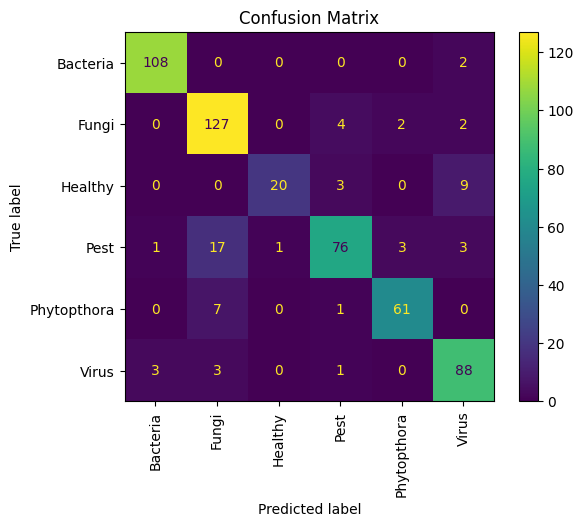

In [35]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_y = prepared_test[:]["label"]
test = prepared_test[:]["pixel_values"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test = test.to(device)

# Make predictions
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    logits = model(test).logits
    pred_y = torch.argmax(logits, dim=-1).cpu().tolist()

# Get the class names from your ImageFolder structure
class_names = labels.names

# Calculate the confusion matrix
cm = confusion_matrix(true_y, pred_y)

# Display the confusion matrix with class names
cm_display = ConfusionMatrixDisplay(cm, display_labels=class_names)
cm_display.plot(xticks_rotation='vertical', values_format='d') # Rotate x-axis labels for better readability
plt.title('Confusion Matrix')
plt.show()